# LSTM basé sur 2 températures pour prédire la mort des chiots


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as kl
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf


In [4]:
dataset = pd.read_csv('Data.csv')

In [5]:
x_1 = dataset['TRD27']
x_2 = dataset['TRD35']
y = dataset['Died']

x_1 = x_1.values[0:100]
x_2 = x_2.values[0:100]
y = y.values[0:100]
print(len(x_1))


100


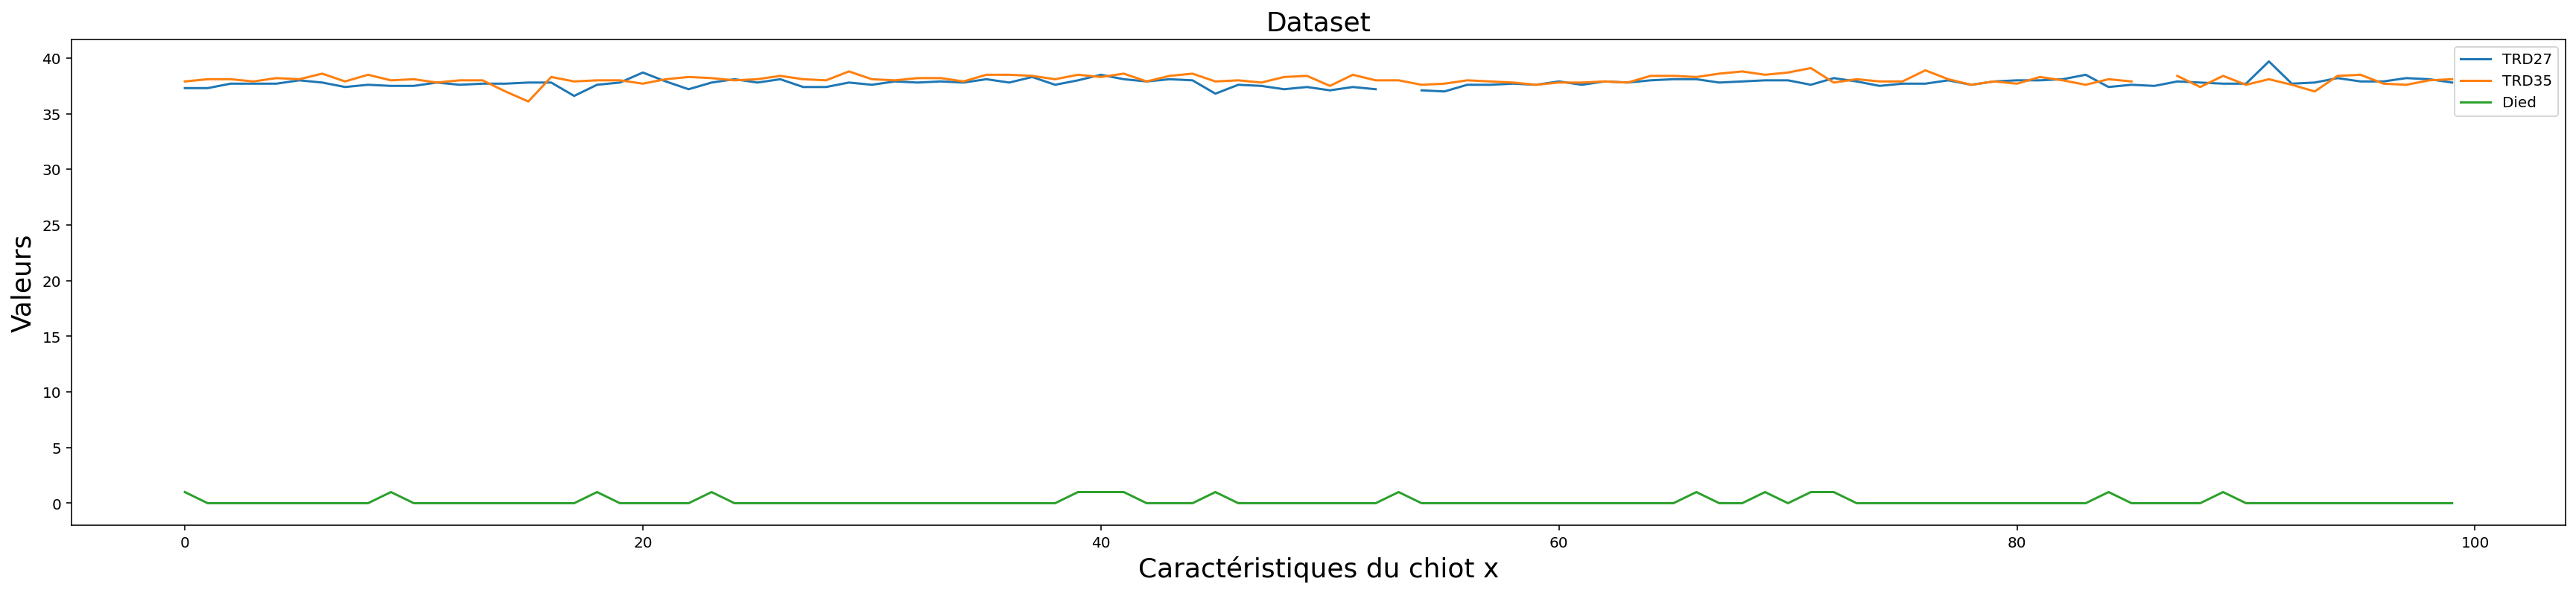

In [6]:
plt.figure(figsize=(30, 6))
plt.plot(x_1[:100] , label='TRD27')
plt.plot(x_2[:100] , label='TRD35')
plt.plot(y[:100] , label='Died')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Caractéristiques du chiot x' ,  fontsize=18)
plt.ylabel('Valeurs' , fontsize=18)
plt.legend()
plt.show()

In [31]:
# convert to [rows, columns] structure
x_1 = x_1.reshape((len(x_1), 1))
x_2 = x_2.reshape((len(x_2), 1))
y = y.reshape((len(y), 1))

print ("x_1.shape" , x_1.shape) 
print ("x_2.shape" , x_2.shape) 
print ("y.shape" , y.shape) 


x_1.shape (167, 1)
x_2.shape (167, 1)
y.shape (167, 1)


In [33]:
# normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(x_1)
x_2_scaled = scaler.fit_transform(x_2)
y_scaled = scaler.fit_transform(y)

# horizontally stack columns
dataset_stacked = hstack((x_1_scaled, x_2_scaled, y_scaled))

print ("dataset_stacked.shape" , dataset_stacked.shape) 

dataset_stacked.shape (167, 3)


In [34]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [9]:
# integer encode direction to transform text in data understandable by the model
encoder = LabelEncoder()
x_1 = encoder.fit_transform(x_1)
# ensure all data is float
x_1 = x_1.astype('float32')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [11]:
# choose a number of individual steps #change this accordingly
n_steps_in, n_steps_out = 30 , 30 

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

print ("X.shape" , X.shape) 
print ("y.shape" , y.shape) 

X.shape (109, 30, 2)
y.shape (109, 30)


In [12]:
split = 1
train_X , train_y = X[:split, :] , y[:split, :]
test_X , test_y = X[split:, :] , y[split:, :]

n_features = train_X.shape[2]

# LTSM MODEL PARAMETER SETTING

In [13]:
print ("train_X.shape" , train_X.shape) 
print ("train_y.shape" , train_y.shape) 
print ("test_X.shape" , test_X.shape) 
print ("test_y.shape" , test_y.shape) 
print ("n_features" , n_features)

train_X.shape (1, 30, 2)
train_y.shape (1, 30)
test_X.shape (108, 30, 2)
test_y.shape (108, 30)
n_features 2


In [35]:
#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.0001)
# define model
model = Sequential()
model.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(30, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 10)            520       
                                                                 
 lstm_9 (LSTM)               (None, 10)                840       
                                                                 
 dense_3 (Dense)             (None, 30)                330       
                                                                 
 activation_4 (Activation)   (None, 30)                0         
                                                                 
Total params: 1,690
Trainable params: 1,690
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Fit network
#history = model.fit(train_X , train_y , epochs=30 , steps_per_epoch=3 , verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)
# Fit network
history = model.fit(train_X , train_y , epochs=40 , batch_size= 50 ,steps_per_epoch=2, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)

Epoch 1/40
2/2 [==============================] - 0s 67ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: nan - val_mse: nan
Epoch 2/40
2/2 [==============================] - 0s 42ms/step - loss: 0.0548 - mse: 0.0548 - val_loss: nan - val_mse: nan
Epoch 3/40
2/2 [==============================] - 0s 41ms/step - loss: 0.0546 - mse: 0.0546 - val_loss: nan - val_mse: nan
Epoch 4/40
2/2 [==============================] - 0s 43ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: nan - val_mse: nan
Epoch 5/40
2/2 [==============================] - 0s 41ms/step - loss: 0.0541 - mse: 0.0541 - val_loss: nan - val_mse: nan
Epoch 6/40
2/2 [==============================] - 0s 47ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: nan - val_mse: nan
Epoch 7/40
2/2 [==============================] - 0s 44ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: nan - val_mse: nan
Epoch 8/40
2/2 [==============================] - 0s 40ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: nan - val_mse: nan
Epoch 9/40
2/2 [